# Chicago Food Inspection

## Executive Summary

#### Problem Definition
This data science project aims to optimize the Food Inspection process at Chicago city by trying to predict the restaurants that contain food violations, especially critical & serious violations, as defined by Chicago's Food Inspection Reporting System. The status of an inspection can be Pass, Pass with Conditions, or Fail, depending on the type of violations found. To create a predictive model, we used data about the weather, community area features, restaurant chain size, restaurant risk level, and the number and percentage of past failed visists. We noticed in our analysis that restaurants with more than one inspection behave differently than restaurants with only one or two inspections. Therefore, we creates two models, one using all observations, and the second using only restaurants with one or two past inspection visits.

#### Research Question
According to the inspection process, we would like to predict restaurants that would pass with conditions or fail, because those are the restaurants that contain serious or critical violations. We would like to create a model that predicts whether a restaurant requires inspection, based on the data we have on past inspections. Therefore, we would like to predict whether an observation belongs to one of two classes: 
- Pass
- Pass wth Conditions or Fail

#### Model Evaluation
When evaluating our model, we would like to increase Precision.We want to try to catch all restaurants with violations, and do not mind catching some restaurants without violations in the process. In other words, we do not want to miss the restaurants with critical and serious violations.

We used four classification models: 
- Logistic Regression
- Decision Trees
- Random Forrests
- XGBoost 

XGBoost returned 83.6%, the highest Accuracy among all models.

#### Results & Recommendations
According to our analysis and our models' feature importance, the feature that has the highest correlation with the results of an inspection is the percentage of past failed inspections. Other features also correlated with an inspection's results, but very weakly. We created two models, one for the complete dataset, and another for the observations with more than two insepctions. According to our results, the first model outperformed the second one.

Our recommendation for future work is to add more features to the dataset, mainly features about the restaurants themselves. Other than the restaurant risk level and the chain size, our dataset was lacking information about the restaurants themselves, such as the type of cuisine, the price range, and customer ratings from social media. 

Furthermore, the community area could be investigated further. According to the feature importance of the models, some community areas are either positively or negatively correlated with the results of an inspection. We could add a feature that represents the 9 regions of Chicago, they might show a pattern that we could not see with 77 community areas. 

## Table of Content
- Import and Preprocess Data
- Exploratory Data Analysis
- Feature Re-engineering
    - Regions	
        - Crime
        - Sanitation
        - Poverty, Education & Unemployment
    - Frequency of Inspections & Failures
    - Number of branches per restaurant (Restaurant Chain Sizes)
    - Weather
        - Season
        - Temperature and Humidity
        - Three consecutive days of high Temperature
    - Violations
    - Yelp Data
- Modeling
    - Model 1: All Restaurants
    - Model 2: Restaurants with 3 and more Inspection Visits
- conclusion


----

# Import and Preprocess Data

#### Dataset
The dataset has been downloaded from the Chicago Data Portal as a csv file on May 8th, 2019. According to the Chicago Data Portal, the data was last updated on May 7th, 2019. The data covers observations from 2010-01-04 to 2019-05-07. The dataset is available on the following link: https://data.cityofchicago.org/Health-Human-Services/Food-Inspections/4ijn-s7e5.


In [691]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [692]:
df = pd.read_csv("DATA/Food_Inspections.csv")

In [693]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2288224,"LA V BAKERY, INC","LA V BAKERY, INC",2550054.0,Bakery,Risk 2 (Medium),2338 S KEDZIE ...,CHICAGO,IL,60623.0,...,Out of Business,NaN,41.848790,-87.705311,(41.8487904950...,36.0,21569.0,32.0,291.0,1.0
1,2288211,SUBWAY,SUBWAY,1495274.0,Restaurant,Risk 1 (High),3167 N LINCOLN...,CHICAGO,IL,60657.0,...,Pass w/ Condit...,"3. MANAGEMENT,...",41.939425,-87.668111,(41.9394246216...,16.0,4449.0,57.0,712.0,40.0
2,2288212,DO-RITE DONUTS...,DO-RITE DONUTS...,2621370.0,Restaurant,Risk 1 (High),1027 W ADDISON...,CHICAGO,IL,60613.0,...,Pass,41. WIPING CLO...,41.947117,-87.655460,(41.9471165370...,38.0,4449.0,57.0,211.0,25.0
3,2288241,KAI SUSHI,KAI SUSHI,2569284.0,Restaurant,Risk 1 (High),3819 N SOUTHPO...,CHICAGO,IL,60613.0,...,Fail,1. PERSON IN C...,41.951337,-87.663988,(41.9513368355...,38.0,21186.0,57.0,725.0,25.0
4,2288221,PALETERIA AYUTLA,PALETERIA AYUTLA,2321232.0,Restaurant,Risk 2 (Medium),2404 W 46TH PL,CHICAGO,IL,60632.0,...,Pass w/ Condit...,"3. MANAGEMENT,...",41.809457,-87.684746,(41.8094569173...,29.0,14924.0,55.0,687.0,3.0


In [694]:
df.shape

(186426, 22)

### preprocessing column names

In [695]:
df.columns = df.columns.map(lambda x: x.lower())
df.columns = df.columns.map(lambda x: x.replace(' ','_'))
df.rename(columns={"license_#":"license_num"}, inplace=True)

In [696]:
df.head();

### Filtering

Before filtering based on the inspection type, we need to remove entries without an inspection type:

In [697]:
df.inspection_type.isnull().sum()

1

In [698]:
df[df.inspection_type.isnull()].iloc[:,8:15]

,state,zip,inspection_date,inspection_type,results,violations,latitude
55362,IL,60614.0,07/14/2016,NaN,Pass,NaN,41.930833


There is one observation with NaNs as values for the inspection type and violations, therefore it will be useless for our analysis and we will delete it

In [699]:
null_rows = df[df.inspection_type.isnull()].index
df.drop(null_rows,inplace=True)

### a. filter by inspection type

Canvas inspections occur throughout the year and are somewhat random inspections of various restaurants

In [700]:
df = df.loc[df.inspection_type.str.contains("canvas", case=False)]

In [701]:
df.shape

(118179, 22)

In [702]:
df.inspection_type.value_counts()

Canvass                              98792
Canvass Re-Inspection                19380
CANVASS/SPECIAL EVENT                    1
CANVASS                                  1
CANVASS RE INSPECTION OF CLOSE UP        1
CANVASS SPECIAL EVENTS                   1
CANVASS FOR RIB FEST                     1
CANVASS SCHOOL/SPECIAL EVENT             1
CANVAS                                   1
Name: inspection_type, dtype: int64

We are not interested in Canvass Re-Inspection, therefore we need to filter it too

In [703]:
df = df.loc[df.inspection_type!="Canvass Re-Inspection"]

In [704]:
df.shape

(98799, 22)

### b. filter by facility type

In [705]:
df = df[df.facility_type == "Restaurant"]

In [706]:
df.shape

(66136, 22)

### c. filter observations before 2013

Convert the Inspection Date to datetime before filtering

In [707]:
df.inspection_date = pd.to_datetime(df.inspection_date)

In [708]:
df = df[df['inspection_date'] > '2013-01-01']

In [709]:
df.shape

(50935, 22)

### Cleaning Data

 I noticed during visualization that the license number 0 is very random; it corresponds to more than 30 different restaurants. It seems to be an error and it is definately an outlier and distorts the dataset, therefore we will delete it.

In [710]:
df[df.license_num==0];

In [711]:
license_zero = df[df.license_num==0].index

In [712]:
df.drop(license_zero,inplace=True)

While working with the dataset, I noticed some restaurants that are spelled differently in different observations which causes our analysis to work with them as different restaurants.

following is a list of mistakes found:

SUBWAY
Subway
SUBWAY SANDWICHES

KFC
KENTUCKY FRIED CHICKEN 

MC DONALD'S 
MCDONALD'S  
MCDONALDS 

POTBELLY SANDWICH WORKS LLC 
POTBELLY SANDWICH WORKS

JIMMY JOHN'S
JIMMY JOHNS

DUNKIN DONUTS / BASKIN ROBBINS
DUNKIN DONUTS/BASKIN ROBBINS 

DOMINO'S
DOMINO'S PIZZA

We will correct these mistakes manually.

In [713]:
#df[df.dba_name=='Subway'].dba_name = "SUBWAY"
df.loc[df.dba_name=='Subway',"dba_name"] = "SUBWAY"
df.loc[df.dba_name=='SUBWAY SANDWICHES',"dba_name"] = "SUBWAY"
df.loc[df.dba_name=='KENTUCKY FRIED CHICKEN',"dba_name"] = "KFC"
df.loc[df.dba_name=="MC DONALD'S","dba_name"] = "MCDONALD'S"
df.loc[df.dba_name=="MCDONALDS","dba_name"] = "MCDONALD'S"
df.loc[df.dba_name=="POTBELLY SANDWICH WORKS LLC","dba_name"] = "POTBELLY SANDWICH WORKS"
df.loc[df.dba_name=="JIMMY JOHNS","dba_name"] = "JIMMY JOHN'S"
df.loc[df.dba_name=="DUNKIN DONUTS / BASKIN ROBBINS","dba_name"] = "DUNKIN DONUTS/BASKIN ROBBINS"
df.loc[df.dba_name=="DOMINO'S","dba_name"] = "DOMINO'S PIZZA"

### Data Types Preprocessing

In [714]:
#df.info()

#### Convert to Integers

In [715]:
df.inspection_id = df.inspection_id.astype(int)

In [716]:
df.license_num = df.license_num.astype(int)

In [717]:
null_rows = df[df.community_areas.isnull()].index
df.drop(null_rows,inplace=True)

In [718]:
df.community_areas = df.community_areas.astype(int)

### Delete unnecessary columns

In [719]:
df.inspection_id.nunique() # each observation has a unique inspection id

49677

In [720]:
df.license_num.nunique()

13019

In [721]:
df.city.value_counts();

In [722]:
df.state.value_counts()

IL    49676
Name: state, dtype: int64

In [723]:
df["historical_wards_2003-2015"].nunique() ,df.zip_codes.nunique(), df.community_areas.nunique(), df.census_tracts.nunique(), df.wards.nunique()

(50, 58, 76, 752, 50)

In [724]:
df.drop(['inspection_id','city','state','inspection_type','facility_type','historical_wards_2003-2015', 'census_tracts'],axis=1,inplace=True);

### Missing Values and Duplicates

In [725]:
sum(df.duplicated())

26

In [726]:
df[df.duplicated()];

In [727]:
df.drop_duplicates(inplace=True)

Missing Values are Violations, they will be resolved in the section "Food Inspection Violations and Results"

 ---------------------------------------------------------------------------------------------------------------

# Exploratory Data Analysis

### Food Inspection Violations and Results

The following table identifies specific Critical, Serious, and Minor Health Code Violations:

- Critical Health Code Violations (V1-14)
- Serious Health Code Violations (V15-29)
- Minor Health Code Violations (V30-44, V70)

#### Critical Violations

This category includes such occurrences as:

- Inadequate storage temperatures
- Inappropriate food handling practices
- Improper personal hygiene
- Rodent and/or insect infestation
- Lack of hot running water

#### Serious Violations

This category includes such occurrences as:

- Potentially hazardous food improperly thawed
- Re-serving food previously served to another customer (except for packaged food in its original unopened packages)
- Food not properly protected from contamination during storage, preparation, display, service, and transportation

#### Minor Violations

This category includes such occurrences as:

- Poorly constructed, unclean, or dilapidated walls, ceilings, or floors
- Improper storage of soiled and clean linens, coats, and aprons
- Unauthorized personnel in the food-prep area

#### Determining Inspection Status/Results
The status of an inspection can be Pass, Pass with Conditions, or Fail.

- A status of Pass is given if the business meets the minimum requirements of the municipal code and does not have Serious or Critical violations present during the inspection.
- A status of Pass with Conditions is given if the business has Serious or Critical violations that are corrected during the inspection or the certified Food Service Sanitation Manager is not present at the time of inspection.
- A status of Fail is given if the business has Serious violations that cannot be corrected during the inspection. The business must correct the Serious violations promptly and pass a re-inspection in order to remain open.
- A status of Fail is also given if the business has Critical violations that cannot be corrected during the inspection. In this situation, the business will have its license suspended until it passes a re-inspection.

#### Resource: City of Chicago's Official Site https://webapps1.cityofchicago.org/healthinspection/Code_Violations.jsp#critical

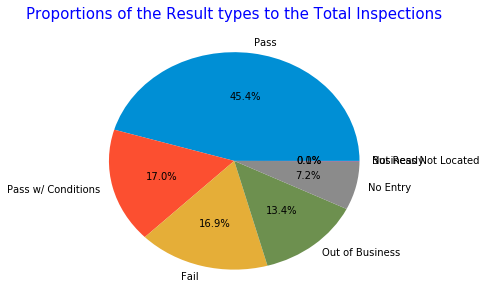

In [728]:
plt.figure(figsize = (5,5))
plt.pie(df.results.value_counts().values,labels=df.results.value_counts().index,autopct='%1.1f%%')
plt.title('Proportions of the Result types to the Total Inspections',color = 'blue',fontsize = 15);

In [729]:
df.results.value_counts()

Pass                    22524
Pass w/ Conditions       8437
Fail                     8401
Out of Business          6670
No Entry                 3585
Not Ready                  25
Business Not Located        9
Name: results, dtype: int64

### Violations Column for Results other than Pass and Fail

In [730]:
df[df.results=="Out of Business"].violations.isna().sum()

6660

In [731]:
df[df.results=="No Entry"].violations.isna().sum()

3480

In [732]:
df[df.results=="Not Ready"].violations.isna().sum()

24

In [733]:
df[df.results=="Business Not Located"].violations.isna().sum()

9

The classes "Out of Business", "No Entry", "Not Ready" and "Business Not Located" do not indicate the presence of serious or critical violations because they are not classified as pass or fail or pass wth conditions. Moreover, the Violations column is almost completely empty for these observations. They do not indicate the presence of serious or critical violations neither by result of inspection nor by violations. Therefore, they are not indicative of our model's target variable and will be deleted. Another solution would be to predict their results based on their past inspections whenevr present. However this would be a lengthy errorsome process, and we already have enough data to work without these observations. 

In [734]:
df.drop(df[df.results=="Out of Business"].index, inplace=True)
df.drop(df[df.results=="No Entry"].index, inplace=True)
df.drop(df[df.results=="Not Ready"].index, inplace=True)
df.drop(df[df.results=="Business Not Located"].index, inplace=True)

### Restaurant Risk Levels 

#### Determining the Risk Level of a Restaurant
At the time of licensing, the risk type of the business is determined based on the complexity of food handling practices and the type of food served. Subsequent inspections are determined by risk type. Establishments are categorized as Risk 1, Risk 2, or Risk 3 depending on the type of operation and the potential for causing a food-borne illness. Risk 1 establishments are considered to be high-risk and have complex menus with more risky food handling practices, whereas, Risk 3 establishments are considered to be low-risk and have food that may be packaged in a commercially inspected facility or are nonperishable. 

#### frequency of inspections
The frequency of inspections that an establishment receives per year depends upon its risk type. As a general rule, Risk 1 establishments are inspected at least twice per calendar year; Risk 2 establishments are inspected at least once per calendar year; and Risk 3 establishments are inspected every two years. However, there are many exceptions to this rule, such as additional inspections in response to complaints or suspected food-borne illnesses.

#### Resource: City of Chicago's Official Site https://webapps1.cityofchicago.org/healthinspection/General_Info.jsp

In [735]:
df.risk.value_counts()

Risk 1 (High)      33704
Risk 2 (Medium)     5537
Risk 3 (Low)         121
Name: risk, dtype: int64

### Proportions of restaurants with risk 1, 2 & 3

It is important to note here that risk1 restaurants are inspected more often, therefore their observations are repeated. To find out how many restaurants are high risk, we need to view by Branch and counting each branch once only (ignoring repeated visits).

#### This is because Risk is an attribute of the restaurant, not the observations.

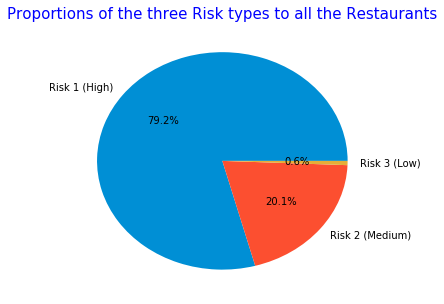

In [736]:
restaurants = df.drop_duplicates(subset='license_num')

risk_proportions = restaurants.risk.value_counts()
labels = risk_proportions.index
sizes = risk_proportions.values

plt.figure(figsize = (5,5))
plt.pie(sizes,labels=labels,autopct='%1.1f%%')
plt.title('Proportions of the three Risk types to all the Restaurants',color = 'blue',fontsize = 15);

### Risk vs Results

In [737]:
risk1_results = df[df.risk=="Risk 1 (High)"].results.value_counts()
risk2_results = df[df.risk=="Risk 2 (Medium)"].results.value_counts()
risk3_results = df[df.risk=="Risk 3 (Low)"].results.value_counts()

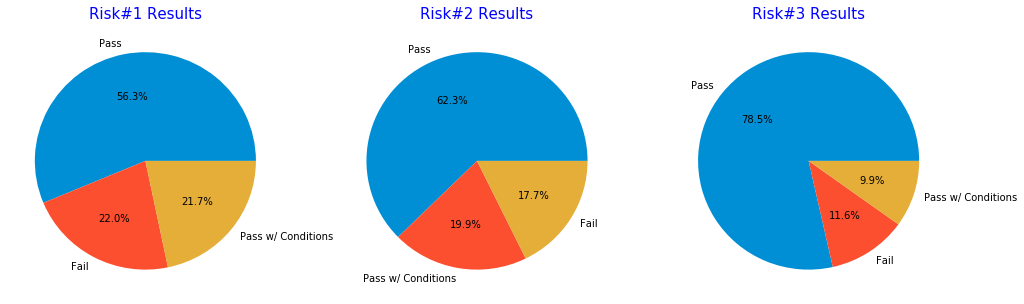

In [738]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.pie(risk1_results.values, labels=risk1_results.index, autopct='%1.1f%%')
plt.title('Risk#1 Results',color = 'blue',fontsize = 15)
plt.subplot(1,3,2)
plt.pie(risk2_results.values, labels=risk2_results.index, autopct='%1.1f%%')
plt.title('Risk#2 Results',color = 'blue',fontsize = 15)
plt.subplot(1,3,3)
plt.pie(risk3_results.values, labels=risk3_results.index, autopct='%1.1f%%')
plt.title('Risk#3 Results',color = 'blue',fontsize = 15);

According to the pie charts above, there is a higher probability of finding serious and critical violations when inspecting high risk restaurants. The probability decreases with the decrease of the risk level.

## Results Transformation

Since we are interested in only two classes: 
- Pass 
- Fail or Pass with conditions 

We will combine the two classes Fail and Pass with Conditions. We will also convert the results from categorical to binary, 1 for failing, 0 for passing. 

From this point forward, when we refer to failing, it includes both the fail results and the pass with conditions results. 

In [739]:
df.loc[df.results == 'Fail', "results"] = 'Fail'
df.loc[df.results == 'Pass w/ Conditions', "results"] = 'Fail'
df['results'] = df['results'].apply({'Fail':1, 'Pass':0}.get)

-----

# Feature Re-engineering

## Regions

An important aspect of analysing our dataset is the location of the restaurant. Various information has been provided to indicate the location of a restarant: address, coordinates, ward, and community area. We will use the community area because it is available in external datasets that we would like use to enrich the information in our dataset.

Chicago is made up of 77 community areas (from 1 to 77) that are often grouped into 9 districts or “sides.” The community areas are well defined and do not overlap. 

#### Here we will make an assumption that community areas have the same size and same population size in order to simplify our calculations. 

#### It is important to note that when we study a community area in this dataset, the area is repeated due to multiple inspections of the same restaurant in the same area.

### External Data about Chicago's Community Areas

In order to read external data in Rds format, we need to import the rpy2 library:

In [740]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

pandas2ri.activate()
readRDS = robjects.r['readRDS']

### Crime 

The crime dataset represents crime in the city of Chicago from 2001 to 2014. This dataset was downloaded from https://github.com/Chicago/food-inspections-evaluation/tree/master/DATA. The only type of crime registered in this dataset is Burglary.

In [741]:
crime = readRDS('DATA/12_crime.Rds')
crime = pandas2ri.ri2py(crime)

C:\Users\noura\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [742]:
crime.head(2)

,ID,Case_Number,Date,Block,IUCR,Primary_Type,Description,Location_Description,Arrest,Domestic,...,Ward,Community_Area,FBI_Code,X_Coordinate,Y_Coordinate,Year,Updated_On,Latitude,Longitude,Location
0,1310263.0,G000647,11323,053XX W SCHOOL ST,610.0,BURGLARY,FORCIBLE ENTRY,RESIDENCE-GARAGE,0,0,...,NaN,NaN,5.0,1139920.0,1921456.0,2001.0,13238,41.940578,-87.761156,"(41.940577989,..."
1,1310374.0,G000129,11323,010XX W FOSTER AV,620.0,BURGLARY,UNLAWFUL ENTRY,APARTMENT,0,0,...,NaN,NaN,5.0,1167952.0,1934657.0,2001.0,13238,41.976242,-87.657746,"(41.97624237, ..."


In [743]:
crime.Community_Area.isnull().sum()

32597

In [744]:
null_community_area = crime[crime.Community_Area.isnull()].index
crime.drop(null_community_area,inplace=True)

In [745]:
crime.Community_Area = crime.Community_Area.astype(int)

In [746]:
community_area_crime_frequency = crime.Community_Area.value_counts()

In [747]:
df['crime_frequency'] = df.community_areas.apply(lambda x:community_area_crime_frequency[x])

------------------------------------------------------------------------------------------------------------------------

### Sanitation

This dataset was downloaded from https://github.com/Chicago/food-inspections-evaluation/tree/master/DATA. After going through the sanitation dataframe, it seems that the observations correspond to sanitation code violations. The observations are registered along with the community area number, therefore we will use the frequency of the occurrence of a community area to represent the number of sanitation code violations in a community area. This number represents a proxy for the sanitation of that community area.

In [748]:
sanitation = readRDS('DATA/15_sanitation_code.Rds')
sanitation = pandas2ri.ri2py(sanitation)

C:\Users\noura\Anaconda3\lib\site-packages\rpy2-2.9.4-py3.6-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [749]:
sanitation.head(2)

,Creation_Date,Status,Completion_Date,Service_Request_Number,Type_of_Service_Request,What_is_the_Nature_of_this_Code_Violation,Street_Address,ZIP_Code,X_Coordinate,Y_Coordinate,Ward,Police_District,Community_Area,Latitude,Longitude,Location
0,10959,Completed,15061,00-00002158,Sanitation Cod...,,4853 S WOOD,NaN,1.165167e+06,1.872509e+06,20.0,9.0,61.0,41.805763,-87.669757,(41.8057634358...
1,10959,Completed,15061,00-00002178,Sanitation Cod...,,4837 S DAMEN,NaN,1.163839e+06,1.872588e+06,20.0,9.0,61.0,41.806008,-87.674623,(41.8060077431...


In [750]:
sanitation.Community_Area.isnull().sum()

4

In [751]:
null_community_area = sanitation[sanitation.Community_Area.isnull()].index

In [752]:
sanitation.drop(null_community_area,inplace=True)

In [753]:
sanitation.Community_Area = sanitation.Community_Area.astype(int)

In [754]:
sanitation.Community_Area.value_counts();

In [755]:
sanitation[sanitation.Community_Area == 0]

,Creation_Date,Status,Completion_Date,Service_Request_Number,Type_of_Service_Request,What_is_the_Nature_of_this_Code_Violation,Street_Address,ZIP_Code,X_Coordinate,Y_Coordinate,Ward,Police_District,Community_Area,Latitude,Longitude,Location
1344,15016,Completed,15037,11-00239034,Sanitation Cod...,Dumpster not b...,7216 W IRVING ...,0.0,1.127172e+06,1.925811e+06,0.0,31.0,0,41.952754,-87.807912,(41.9527535522...
1567,15019,Completed,15044,11-00254652,Sanitation Cod...,Other,5135 N ORIOLE AVE,0.0,1.124674e+06,1.933462e+06,0.0,31.0,0,41.973790,-87.816924,(41.9737901959...
16359,15281,Completed,15310,11-04067254,Sanitation Cod...,,11900 S ASHLAN...,60643.0,1.167819e+06,1.825805e+06,0.0,0.0,0,41.677544,-87.661365,(41.6775442597...


After checking the unique values of Community areas in the dataframe, we found 3 entries with the community area number 0. I searched online for these three locations using the given addresses and zip codes when provided. The first two observations are in an area named "Norridge". The third observation is in "Calumet Park". Norridge and Calumet Park are not included in the 77 community areas of Chicago. Therefore, these three observations will be deleted. 

In [756]:
sanitation.drop(sanitation[sanitation.Community_Area == 0].index,inplace=True)

In [757]:
sanitaion_community_areas = sanitation.Community_Area.value_counts()

In [758]:
df['sanitation_reports'] = df.community_areas.apply(lambda x:sanitaion_community_areas[x])

-----------------------------------------------------------------------------------------------------------------

### Poverty, Education & Unemployment

Based on Census Data - Selected socioeconomic indicators in Chicago, 2008 – 2012
This dataset contains a selection of six socioeconomic indicators of public health significance and a “hardship index,” by Chicago community area, for the years 2007 – 2011.  The hardship index is a score that incorporates each of the
six selected socioeconomic indicators. Scores on the index can range from 1 to 100, with a higher
index number representing a greater level of hardship. The scores are standardized according to the
data for the 77 community areas.

In [759]:
poverty = pd.read_csv('DATA/below_poverty_level_by_community.csv')

In [760]:
poverty.head(2)

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,5.0,North Center,0.3,7.5,5.2,4.5,26.2,57123,6.0
1,75.0,Morgan Park,0.8,13.2,15.0,10.8,40.3,27149,30.0


In [761]:
poverty[poverty["Community Area Number"].isnull()]

,Community Area Number,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
47,NaN,CHICAGO,4.7,19.7,12.9,19.5,33.5,28202,NaN


In [762]:
poverty.drop(47,inplace=True)

In [763]:
poverty["Community Area Number"] = poverty["Community Area Number"].astype(int)

#### Add the hardship index to our dataframe

In [764]:
hardship = poverty[['Community Area Number','HARDSHIP INDEX']].set_index('Community Area Number')

In [765]:
df['hardship_index'] = df.apply(lambda row: hardship.loc[row.community_areas,'HARDSHIP INDEX'],axis=1)

#### Add the community area name to our dataframe

In [766]:
community_name = poverty[['Community Area Number','COMMUNITY AREA NAME']].set_index('Community Area Number')

In [767]:
df['community_name'] = df.apply(lambda row: community_name.loc[row.community_areas,'COMMUNITY AREA NAME'],axis=1)

### Community Areas Crime, Sanitation & Hardship Index 

In [768]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [769]:
y1 = ss.fit_transform(df.crime_frequency.values.reshape(-1, 1))
y2 = ss.fit_transform(df.sanitation_reports.values.reshape(-1, 1))
y3 = ss.fit_transform(df.hardship_index.values.reshape(-1,1))

C:\Users\noura\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\noura\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\noura\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\noura\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [770]:
y1.shape = (39362, )

In [771]:
y2.shape = (39362, )

In [772]:
y3.shape = (39362, )

C:\Users\noura\Anaconda3\lib\site-packages\matplotlib\legend.py:938: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000001D487AAB1D0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\noura\Anaconda3\lib\site-packages\matplotlib\legend.py:938: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000001D487AAB1D0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\noura\Anaconda3\lib\site-packages\matplotlib\legend.py:938: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000001D487AAB1D0> instances.
A proxy artist may be used instead.
Se

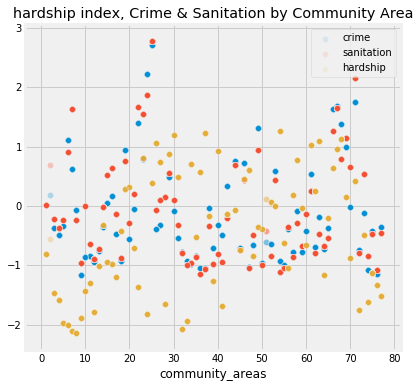

In [773]:
plt.figure(figsize=(6,6))
crime_plot = sns.scatterplot(x=df.community_areas,y=y1, alpha=0.1, label='crime') #crime
sanitation_plot = sns.scatterplot(x=df.community_areas,y=y2, alpha=0.1, label='sanitation') #sanitation
hardship_plot = sns.scatterplot(x=df.community_areas,y=y3, alpha=0.1, label='hardship') #hardship
plt.legend(handles=[crime_plot,sanitation_plot,hardship_plot])
plt.title('hardship index, Crime & Sanitation by Community Area')

plt.legend();

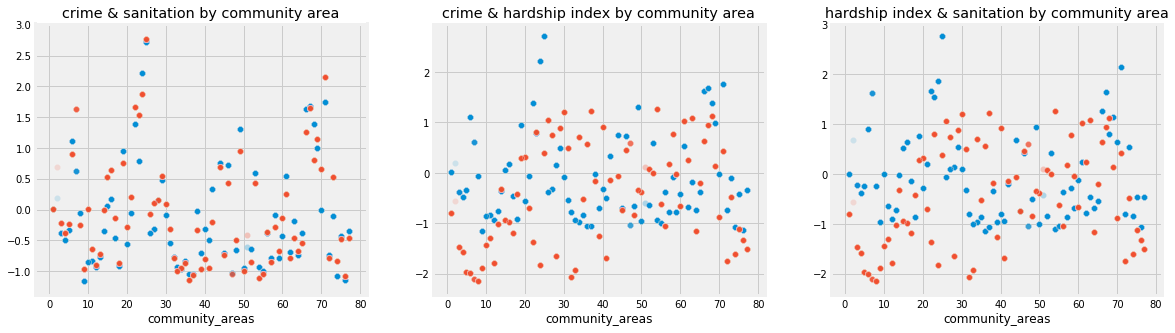

In [774]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.scatterplot(x=df.community_areas,y=y1, alpha=0.05) #crime
sns.scatterplot(x=df.community_areas,y=y2, alpha=0.05) #sanitation
plt.title('crime & sanitation by community area')
plt.subplot(1,3,2)
sns.scatterplot(x=df.community_areas,y=y1, alpha=0.05) #crime
sns.scatterplot(x=df.community_areas,y=y3, alpha=0.05) #hardship
plt.title('crime & hardship index by community area')
plt.subplot(1,3,3)
sns.scatterplot(x=df.community_areas,y=y2, alpha=0.05) #sanitation
sns.scatterplot(x=df.community_areas,y=y3, alpha=0.05);#hardship
plt.title('hardship index & sanitation by community area');

In [775]:
s = df.pivot_table(index=["community_areas",'hardship_index'], aggfunc='count')['sanitation_reports']

#### Community Areas with highest crime reports

In [776]:
np.unique(df[df.crime_frequency >8000].community_areas)

array([ 6, 22, 24, 25, 49, 66, 67, 68, 71])

#### Community Areas with highest sanitation reports

In [777]:
np.unique(df[df.sanitation_reports>2000].community_areas)

array([ 7, 22, 23, 24, 25, 66, 67, 71])

#### Community Areas with highest hardship index

In [778]:
np.unique(df[df.hardship_index > 80].community_areas)

array([23, 26, 27, 29, 30, 34, 37, 40, 54, 58, 61, 63, 67, 68])

There is an overlap between the crime and sanitation levels of community areas, but not with the hardship index. This can be seen visually

----------------

#### Top Five Community Areas with the largest number of restaurants

In [779]:
restaurants = df.drop_duplicates('license_num')
restaurants.community_areas.value_counts()[:7]

37    1068
38     983
29     723
57     695
25     544
68     483
23     317
Name: community_areas, dtype: int64

#### Top Five Community Areas with the largest number of failing restaurants

In [780]:
restaurants[restaurants.results==1].community_areas.value_counts()[:7]

37    668
38    521
29    455
57    408
25    303
68    294
23    203
Name: community_areas, dtype: int64

#### Top Five Community Areas with the largest number of passing restaurants

In [781]:
restaurants[restaurants.results==0].community_areas.value_counts()[:7]

38    462
37    400
57    287
29    268
25    241
68    189
23    114
Name: community_areas, dtype: int64

We tried to find out which areas contain the highest number of failed inspections, butwe found that the number of passing restaurants and failing restaurants is propotional to the number of restaurants in a community area, and consistent across the top 7 community area. Therefore we did not find any trend here. 

---

### Crime, Sanitation & Hardship Index vs Results

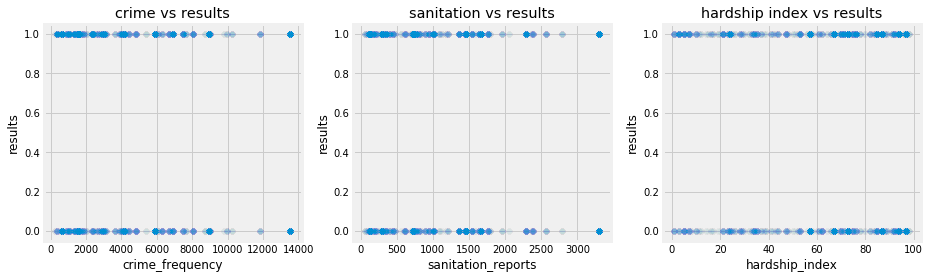

In [785]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.scatterplot(restaurants.crime_frequency,restaurants.results, alpha=0.007)
plt.title('crime vs results')
plt.subplot(1,3,2)
sns.scatterplot(restaurants.sanitation_reports,restaurants.results, alpha=0.007)
plt.title('sanitation vs results')
plt.subplot(1,3,3)
sns.scatterplot(restaurants.hardship_index,restaurants.results, alpha=0.007)
plt.title('hardship index vs results');

According to the plots above, whether crime rates are high or not does not change the frequency of passes or failures. Same for sanitation and hardship index. Distribution of results looks equal across the two classes regardless of the crime, sanitation & hardship index. Hardship shows some difference between pass and fail results when the hardship index is low, but not a clear difference.

---------------------------------------------------------------------------------------------------------------

## Frequency of Inspections & Failures

#### Number of Inspections per restaurant 

One important aspect of our data is that we have historical data about our observations because some restaurants have already been visited more than once. We would like to know the number of times a restaurant had inspection visits. We use the license number and inspection date to find the number of inspections per restaurant.

In [786]:
num_of_inspections_per_license = df.groupby(["license_num","inspection_date"]).count().reset_index()["license_num"].value_counts()

In [787]:
df["num_inspections"] = df.license_num.apply(lambda x: num_of_inspections_per_license[x] )

#### Number of Failed Inspections per restaurant 

After extracting the number of Inspections, we would like to know the number of inspections where serious or critical violations were found per restaurant (i.e pass with conditions and fail)

In [789]:
df_fail = df[df.results==1]

In [790]:
num_fail_passwthcondition_inspections_per_license = df_fail.groupby(["license_num","inspection_date"]).count().reset_index()["license_num"].value_counts()

In [791]:
def count_failed_insp(x):
    # takes license num
    try: 
        return num_fail_passwthcondition_inspections_per_license[x]
    except:
        return 0

In [792]:
df["num_failed_inspections"] = df.license_num.apply(count_failed_insp)

#### Failed Inspections Percentage for each Restaurant

In [793]:
df['failed_inspections_percentage'] = df["num_failed_inspections"]/df["num_inspections"] 

------------------

Failed Inspections by Restaurant is an attribute of the restaurant, therefore we need to group by the license num and plot the result per restaurant, avoiding the repetition of the visits to the same restaurant.

In [794]:
restaurants = df.drop_duplicates('license_num')

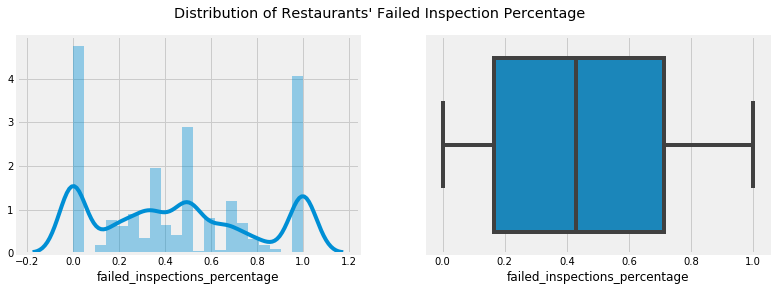

In [795]:
fig = plt.figure(figsize = (12,4))
st = fig.suptitle("Distribution of Restaurants' Failed Inspection Percentage", fontsize="x-large")
plt.subplot(1,2,1)
sns.distplot(restaurants.failed_inspections_percentage)
plt.subplot(1,2,2)
sns.boxplot(restaurants.failed_inspections_percentage);

According to the histogram above, the percentage of past failed inspections is misleading in the case of restaurants with a low number of inspections, especially restaurants with one inspection. This could be an indication that this feature we created can be used with restaurants with more than one inspection but not with restaurants with one inspection.

In [796]:
one_visit = restaurants[(restaurants.num_inspections==1)]

In [797]:
one_visit.failed_inspections_percentage.value_counts()

1.0    1243
0.0    1087
Name: failed_inspections_percentage, dtype: int64

In [798]:
multiple_visits = restaurants[(restaurants.num_inspections>1)]

In [799]:
multiple_visits[multiple_visits.failed_inspections_percentage==0].shape[0]

1297

In [800]:
multiple_visits[multiple_visits.failed_inspections_percentage==1].shape[0]

797

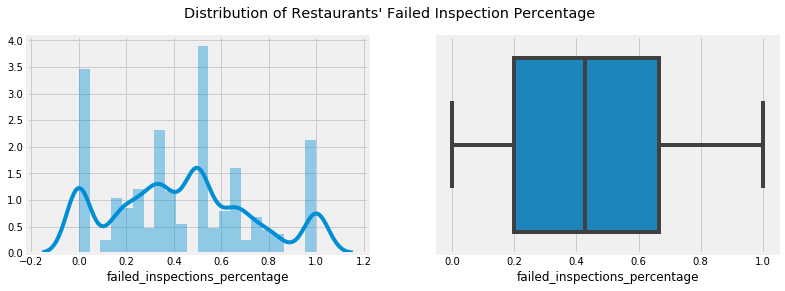

In [801]:
fig = plt.figure(figsize = (12,4))
st = fig.suptitle("Distribution of Restaurants' Failed Inspection Percentage", fontsize="x-large")
plt.subplot(1,2,1)
sns.distplot(multiple_visits.failed_inspections_percentage)
plt.subplot(1,2,2)
sns.boxplot(multiple_visits.failed_inspections_percentage);

We removed restaurants with one inspection and the two spikes at 0 and 1 reduced.

In [802]:
multiple_visits = restaurants[(restaurants.num_inspections>2)]

In [803]:
multiple_visits[multiple_visits.failed_inspections_percentage==0].shape[0]

799

In [804]:
multiple_visits[multiple_visits.failed_inspections_percentage==1].shape[0]

359

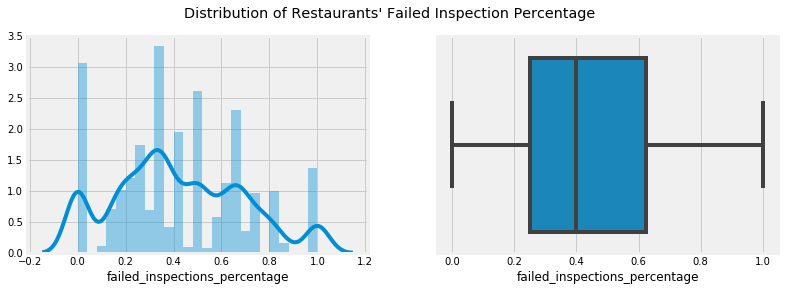

In [805]:
fig = plt.figure(figsize = (12,4))
st = fig.suptitle("Distribution of Restaurants' Failed Inspection Percentage", fontsize="x-large")
plt.subplot(1,2,1)
sns.distplot(multiple_visits.failed_inspections_percentage)
plt.subplot(1,2,2)
sns.boxplot(multiple_visits.failed_inspections_percentage);

We removed restaurants with two inspections and the two spikes at 0 and 1 reduced even further.

----

### Last inspection date

Future Work ..

## Number of branches per restaurant - Restaurant Chain Sizes

#### Here we are making an assumption that the license number represents a branch of a restaurant chain.

I tried to find the number of branches per restaurant once by counting the number of addresses and another time by counting the number of licenses that correspond to a restaurant. However, both approaches are errorsome because a restaurant could relocate and therefore that address wouldnt be available anymore. Also, the license number could change, but it is probably less often for a license number to change than for a restaurant to relocate. Therefore we will use the second approach (counting branches by license number). The number of branches gives a rough estimate of how large a restaurant chain is, even if the number is not very accurate. 



#### Num of Branches by License Number

In [806]:
branches_by_license = df.groupby(["dba_name","license_num"]).count().reset_index()["dba_name"].value_counts()

In [807]:
sum(branches_by_license)

10778

In [808]:
df["num_branches"] = df.dba_name.apply(lambda x: branches_by_license[x] )

### Number of Branches vs Serious & Critical Violations

We would like to know whether the number of branches is correlated with the detection of serious & critical violations. Serious and critical violations result in failing or passing with conditions, according to the city of Chicago's Food Inspection Reporting System. If a restaurant passs, it means there are no serious or critical violations found in the inspection visit.

In order to visualize the relationship between number of branches and serious & critical violations, we need to represent each restaurant once (ex. Subway will have one entry). 

In [809]:
restaurants_branches = df.groupby(['dba_name','num_branches']).count().reset_index('num_branches')['num_branches']

Critical inspections are inspections that found critical & serious violations of the health code. These are present in results labeled as failed or pass with conditions.

In [810]:
critical_inspections = df.loc[df.results==1, 'dba_name'].value_counts()

In [811]:
total_inspections = df.loc[:,'dba_name'].value_counts()

The critical inspections will be geater for restaurants with a lot of branches. Therefore we need to get the ratio of critical inspections to total inspections of a restaurant

In [812]:
critical_ratio = critical_inspections/total_inspections
critical_ratio.fillna(0,inplace=True)

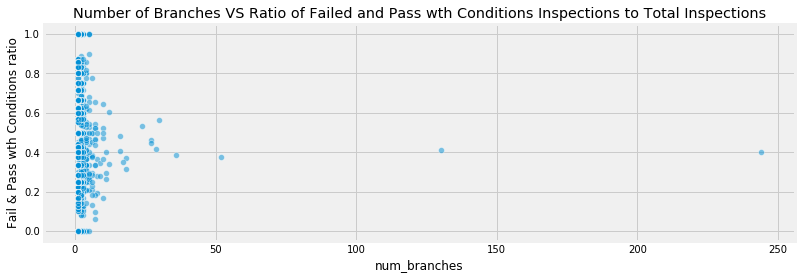

In [813]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=restaurants_branches,y=critical_ratio, alpha=0.5)
plt.ylabel('Fail & Pass wth Conditions ratio')
plt.title('Number of Branches VS Ratio of Failed and Pass wth Conditions Inspections to Total Inspections');

The plot above is distorted by the presence of some outliers. We will remove the three largest chains: Subway, Dunkin Donuts, and Mcdonald's. This will give us a better look at the rest of our data

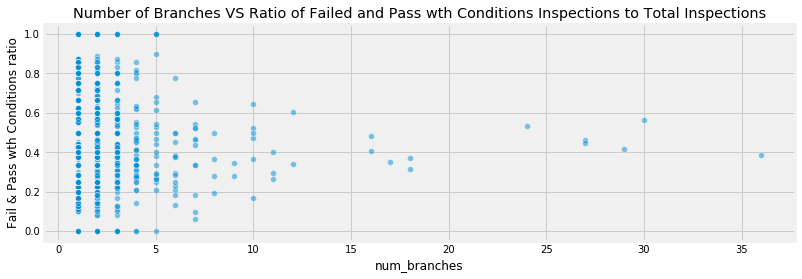

In [814]:
plt.figure(figsize=(12,4))
sns.scatterplot(x=restaurants_branches.drop(["DUNKIN DONUTS","SUBWAY","MCDONALD'S"]),y=critical_ratio.drop(["DUNKIN DONUTS","SUBWAY","MCDONALD'S"]), alpha=0.5)
plt.ylabel('Fail & Pass wth Conditions ratio')
plt.title('Number of Branches VS Ratio of Failed and Pass wth Conditions Inspections to Total Inspections');

We can see from the plot above that single branch restaurants range from 0 to 1 in the ratio of inspections with critical violations to the total number of inspections. The more branches a restaurant has, the closer it gets to a ratio of about 40% of inspections catching critical violations.

This observation is consistent with the histogram of the "past failure ratio" feature. Restaurants that have lots of observation (i.e. have been visited multiple times or have lots of branches) have a result distribution that converges to 40% chance of failing or passing with conditions. 

On the other hand, restaurants that have a few observations (are inspected only once or twice, or have few branches) are difficult to predict. Their results range from 0 to 1.

----

### Restaurant Branches by Food Inspections

We would like to create a column that represents the size of the chain it belongs to. The chain_size column will be a categorical column with the values:
- 1 for restaurants with no branches. 
- 2-6 for restaurants with at least 2 branches and at most 6 branches.
- 7+ for restaurants with 7 branches and more.

This division was chosen based on the previous scatter plot. By visually observing the plot, we see that restaurants with 6 branches and more start to converge to a ratio of 0.4.

In [815]:

df['chain_size'] = df.num_branches.apply(lambda x:'1' if x==1 else '2-6' if 7>x>1 else '7+')

----------------------------------------------------------------------------------------------------------------------------

## Weather

When we study the weather data, we are viewing our data by observation (inspection), not by branch or restaurant. Therefore we do not need to group by a certain column or create pivot tables.

### Season

Create a new column for Season:

In [816]:
df["season"] = df.inspection_date.dt.month
df.season = df.season.apply(lambda x: (x %12 + 3)//3)
df.season = df.season.map({1:"winter",2:"spring",3:"summer",4:"fall"})

### Season vs Results

In [817]:
inspections_per_season = df.season.value_counts()
pass_per_season = df[df.results==0].season.value_counts()
fail_per_season = df[df.results==1].season.value_counts()

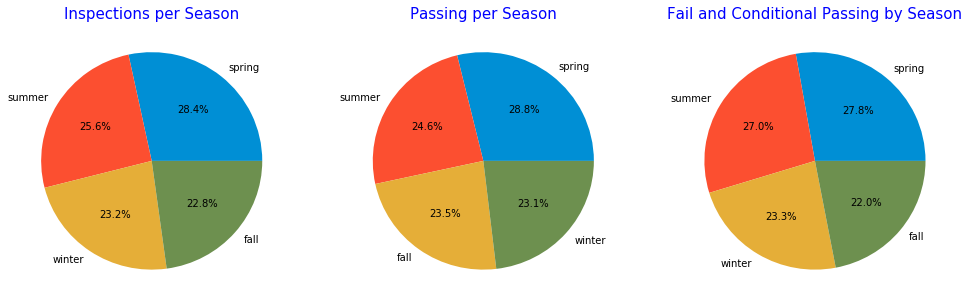

In [818]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.pie(inspections_per_season.values, labels=inspections_per_season.index, autopct='%1.1f%%')
plt.title('Inspections per Season',color = 'blue',fontsize = 15)
plt.subplot(1,3,2)
plt.pie(pass_per_season.values, labels=pass_per_season.index, autopct='%1.1f%%')
plt.title('Passing per Season',color = 'blue',fontsize = 15)
plt.subplot(1,3,3)
plt.pie(fail_and_conditionalpass_by_season.values, labels=fail_and_conditionalpass_by_season.index, autopct='%1.1f%%')
plt.title('Fail and Conditional Passing by Season',color = 'blue',fontsize = 15);

According to the plots above, the probability of passing vs failing or passing wth conditions is approximately consistent accross seasons. There are a bit more failed inspections in the summer, but a very small difference.

### Temperature & Humidity

The weather data for the city of Chicago has been scraped from the website :https://www.wunderground.com/history/monthly/us/il/chicago/KMDW/date/2019-5. After analysing the correlation between the seasons and the inspection results, we do not see a difference in the inspection results among the seasons. Therefore, we scraped the weather data and added it to our dataset. Among the variables given in the weather dataset, we would expect to see a correlation between Temperature and/or Humidity versus inspection results. Contrary to our expectations, we did not see a difference in temperature and humidity between passing and failing inspections. 

According to the literature on the Chicago Food Inspection case, an average of 3 day high temperature has an effect on the inspection results. Therefore, we created a new boolean column to indicate the occurence of three consecutive days with a high temperature. We checked the distribution of the average temperature column and chose the 75% percentile (70 degrees Fahrenheit) as the threshold for high temperature.   

#### Add Weather data to our dataframe

In [819]:
weather = pd.read_csv('DATA/weather_data.csv')

In [820]:
weather.date = pd.to_datetime(weather.date)

Weather data is from 1/1/2010 to 30/4/2019. We need to start from 1/1/2013 to match our Chicago Food Inspections dataset.

In [821]:
weather = weather[weather.date >= '2013-01-01']

In [822]:
weather.head(3)

,Unnamed: 0,Temperature_Max,Temperature_Avg,Temperature_Min,Dew_Point_Max,Dew_Point_Avg,Dew_Point_Min,Humidity_Max,Humidity_Avg,Humidity_Min,Wind_speed_Max,Wind_speed_Avg,Wind_speed_Min,Pressure_Max,Pressure_Avg,Pressure_Min,date
1096,0,27,20,13,9,4,0,64,-,32,14,-,0,30.25,-,30.15,2013-01-01
1097,1,30,21,11,12,6,1,68,-,25,15,-,4,30.27,-,30.15,2013-01-02
1098,2,30,25,19,23,18,12,78,-,55,16,-,7,30.32,-,30.09,2013-01-03


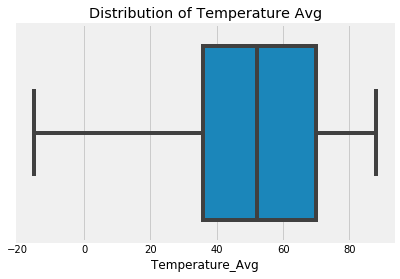

In [823]:
sns.boxplot(weather.Temperature_Avg)
plt.title("Distribution of Temperature Avg");

In [824]:
weather.Temperature_Avg.describe()

count    2311.000000
mean       51.540891
std        20.653584
min       -15.000000
25%        36.000000
50%        52.000000
75%        70.000000
max        88.000000
Name: Temperature_Avg, dtype: float64

In [825]:
weather['is_high_temp'] = weather["Temperature_Avg"].apply(lambda x : 1 if x > 70 else 0)

In [826]:
weather.reset_index(inplace=True)

In [827]:
lst = []
counter = 0
while counter < len(weather["Temperature_Avg"]):
    if counter in [0,1]:
        lst.append(weather.iloc[counter]["is_high_temp"])
    else:
        lst.append(weather.iloc[counter]["is_high_temp"] + weather.iloc[counter-1]["is_high_temp"]+ weather.iloc[counter-2]["is_high_temp"])
    counter += 1

In [828]:
weather['is_3d_high'] = pd.Series(lst)

In [829]:
weather['is_3d_high'].value_counts()

0    1570
3     402
1     186
2     153
Name: is_3d_high, dtype: int64

In [830]:
weather['is_3d_high'] = weather['is_3d_high'].apply(lambda x : 1 if x == 3 else 0)

In [831]:
weather.Humidity_Avg = (weather.Humidity_Max + weather.Humidity_Min)/2

In [832]:
df = df.merge(weather.reset_index()[['date',"Temperature_Avg","Humidity_Avg", 'is_3d_high']], "left", left_on="inspection_date", right_on="date")

In [833]:
df = df.drop(['date'],axis=1)

In [834]:
# Drop the first 13 rows because the temperature & humidity data is not available for them
df.drop(df.index[0:13],inplace=True) 

In [835]:
df.is_3d_high.value_counts()

0.0    32222
1.0     7127
Name: is_3d_high, dtype: int64

In [836]:
df[["Temperature_Avg" ,"Humidity_Avg" , "is_3d_high", "results"]].corr()

,Temperature_Avg,Humidity_Avg,is_3d_high,results
Temperature_Avg,1.000000,0.006520,0.573137,0.026663
Humidity_Avg,0.006520,1.000000,0.047656,0.007881
is_3d_high,0.573137,0.047656,1.000000,0.046583
results,0.026663,0.007881,0.046583,1.000000


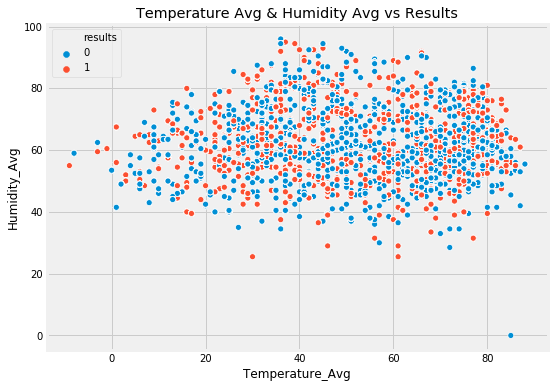

In [837]:
plt.figure(figsize = (8,6))
sns.scatterplot(df.Temperature_Avg, df.Humidity_Avg, hue=df.results)
plt.title('Temperature Avg & Humidity Avg vs Results');

The Scatter plot above shows that there is no correlation between the temperature, humidity, and the results of an inspection. 

C:\Users\noura\Anaconda3\lib\site-packages\matplotlib\legend.py:938: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000001D484376FD0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
C:\Users\noura\Anaconda3\lib\site-packages\matplotlib\legend.py:938: UserWarning: Legend does not support <matplotlib.axes._subplots.AxesSubplot object at 0x000001D484376FD0> instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


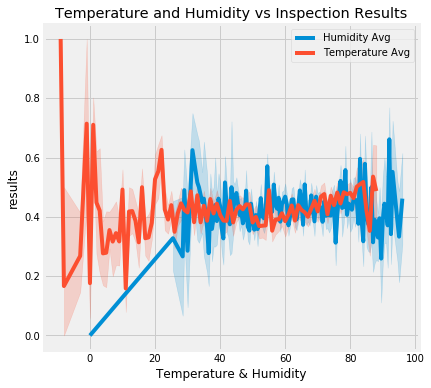

In [838]:
plt.figure(figsize = (6,6))
humid_results = sns.lineplot(df.Humidity_Avg,df.results, label='Humidity Avg')
temp_results = sns.lineplot(df.Temperature_Avg,df.results, label='Temperature Avg')
plt.legend(handles=[humid_results,temp_results])
plt.xlabel('Temperature & Humidity')
plt.title("Temperature and Humidity vs Inspection Results")
plt.legend();

Consistent with the scatter plot, the line plot indicates that there is no strong relationship between the weather and the results. The only conclusion we can make about this chart is that there are more passing inspections when the humidity is low.

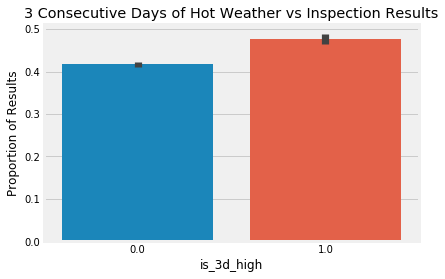

In [839]:
plt.figure(figsize = (6,4))
sns.barplot(df.is_3d_high,df.results)
plt.ylabel('Proportion of Results')
plt.title("3 Consecutive Days of Hot Weather vs Inspection Results");

Contrary to our expectations, there is no visually significant difference in inspection results between a regular day and a day with three consecutive days of higher than average temperature. 

----

## Violations

When we study the violations data, we are viewing our data by observation (inspection), not by branch or restaurant.

In [841]:
df.head();

In [842]:
import re

In [843]:
df['violation_nums'] = df.violations.fillna("0.").apply(lambda x: [int(re.search("(\d+)\.", x).group(1))]+[int(x) for x in re.findall(r'\|\s(\d+)\.',x)])

In [844]:
#pd.set_option('display.max_colwidth',-1)
df.violation_nums[20:50];

In [845]:
df['count_violations'] =  df.violation_nums.apply(lambda x: len(x))

In [846]:
df['count_criticalv'] = df.violation_nums.apply(lambda lis: sum([int(x) in range(1,15) for x in lis]))

In [847]:
df['count_seriousv'] = df.violation_nums.apply(lambda lis: sum([int(x) in range(15,30) for x in lis]))

In [848]:
df['count_minorv'] = df.violation_nums.apply(lambda lis: sum([int(x) in (range(30,45)) for x in lis]))

In [849]:
df['count_otherv'] = df.violation_nums.apply(lambda lis: sum([int(x) in (range(45,70)) for x in lis]))

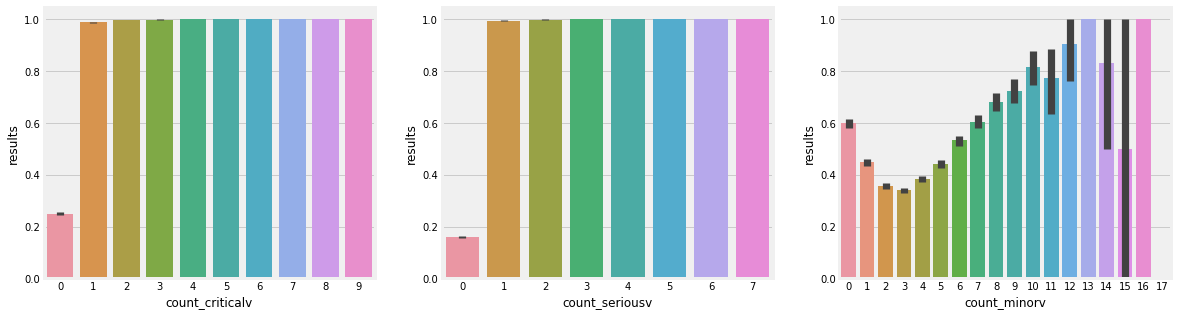

In [850]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.barplot(x=df.count_criticalv,y=df.results)
plt.subplot(1,3,2)
sns.barplot(x=df.count_seriousv,y=df.results)
plt.subplot(1,3,3)
sns.barplot(x=df.count_minorv,y=df.results);

Consistent with our expectations, the presence of critical and serious violations is a strong indicator of passing or not. However, the number of critical and serious violations doesnt seem to make a difference (i.e. whether a restaurant has a lot of serious violations or just a few). 

### Violation Comments

In [851]:
pattern = r'- Comments:\s(.*?)\s\|'
df['violation_comments'] = df.violations.fillna("").apply(lambda x: re.findall(pattern,x))

In [852]:
#pd.set_option('display.max_colwidth',18)

In [853]:
# text=df["violation_comments"]
# words=text.split()
# tokens=word_tokenize(text)
# tokens=[i.lower() for i in words]
# table=str.maketrans("","",string.punctuation)
# stripped=[i.translate(table) for i in tokens]
# words=[words for words in stripped if words.isalpha()]
# stop_words = set(stopwords.words('english'))
# words=[w for w in words if not w in stop_words]
# print(words)

----

## Yelp Data

In [840]:
# MY_API_KEY = "oUz6eQuLtqUHkxtkIZ8HyrNvFoY9TaItnqNOUY7_miB7jo_ShosXJ_vJzku-YaGjR5WdspGmGPwWm7a5HHUeiIFDJDmROwIYtM_LDDvAxCO9NeXd3dHzsfpzIxPYXHYx" #  Replace this with your real API key
# client = Client(MY_API_KEY)

I used the Yelp API, Business Search Endpoint, to retrieve more information about chicago restaurants. But due to limited time, I was not able to integrate the data to our dataframe.

----

### Rearrange New Columns

In [854]:
df.columns

Index(['dba_name', 'aka_name', 'license_num', 'risk', 'address', 'zip',
       'inspection_date', 'results', 'violations', 'latitude', 'longitude',
       'location', 'zip_codes', 'community_areas', 'wards', 'crime_frequency',
       'sanitation_reports', 'hardship_index', 'community_name',
       'num_inspections', 'num_failed_inspections',
       'failed_inspections_percentage', 'num_branches', 'chain_size', 'season',
       'Temperature_Avg', 'Humidity_Avg', 'is_3d_high', 'violation_nums',
       'count_violations', 'count_criticalv', 'count_seriousv', 'count_minorv',
       'count_otherv', 'violation_comments'],
      dtype='object')

In [343]:
# rearrange_columns = ['dba_name', 'aka_name', 'license_num', 'address','community_areas','community_name','hardship_index', 'crime_frequency',
#        'sanitation_reports','inspection_date','num_inspections','num_failed_inspections','failed_inspections_percentage', 'risk', 'results', 'violations', 
#        'num_branches']

# df = df[rearrange_columns]

-----------------

## Heatmap

In [856]:
df_heatmap = df[['results', 'risk', 'hardship_index', 'crime_frequency','sanitation_reports',
    'inspection_date', 'num_inspections','num_failed_inspections','failed_inspections_percentage', 
    'num_branches', 'chain_size','Temperature_Avg','Humidity_Avg','is_3d_high',
    'count_violations', 'count_criticalv', 'count_seriousv', 'count_minorv','count_otherv', ]]

Change Risk and Chain Size from categorical to numerical features before including them in the heatmap

In [857]:
df_heatmap.risk = df['risk'].apply({'Risk 1 (High)':1, 'Risk 2 (Medium)':2, 'Risk 3 (Low)':3}.get)
df_heatmap.chain_size = df['chain_size'].apply({'1':1, '2-6':2, '7+':3}.get)

C:\Users\noura\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


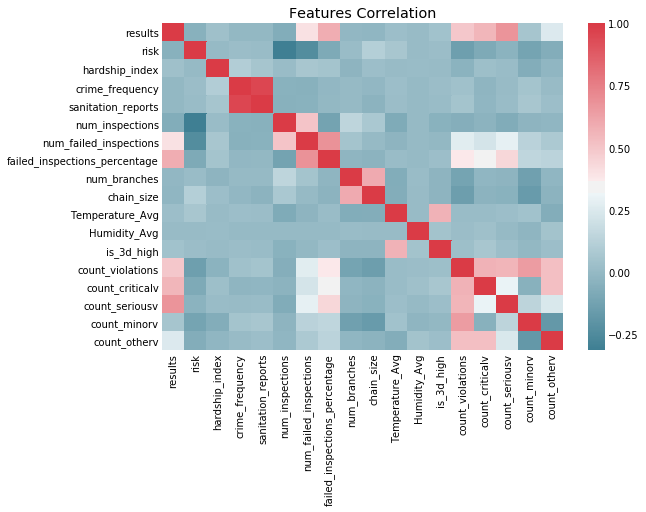

In [858]:
# Compute the correlation matrix
corr = df_heatmap.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.figure(figsize=(8,6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, cmap=cmap)
ax.set_title('Features Correlation');

- Results is correlated with failed_inspection_percentage, count_violation, count_critical, count_serious.

- Risk is negatively correlated with the number of inspections. This is expected because the higher the risk of the restaurant, the more inspection visits would be scheduled for that restaurant.

- Crime and sanitation are positively correlated, consistent with our visualization.

- Some features are derived from others, therfore they naturally correlate on the heatmap. Temperature_avg with is_3d_high, chain_size with num_branches, num_failed_inspections with failed_inspection_percentage.

### PairPlot

In [859]:
#sns.pairplot(df)

# Modeling 

We noticed that inspection results are more predictable for restaurants that have multiple observations (eithe multiple inspections or multiple branches). We would like to create two models, one for all observations, and one for restaurants with multiple inspection (more than two). We expect the second model to have higher accuracy.

In [860]:
df.is_3d_high = df.is_3d_high.apply({1:'T', 0:'F'}.get)

In [861]:
model1_df = df.copy()
model2_df = df[df.num_inspections>=3].copy()

In [862]:
model1_df = model1_df[['community_name','hardship_index', 'crime_frequency',
       'sanitation_reports','failed_inspections_percentage','risk','Humidity_Avg',
       'is_3d_high', 'chain_size', 'results']]
model2_df = model2_df[['community_name','hardship_index', 'crime_frequency',
       'sanitation_reports','failed_inspections_percentage', 'risk','Humidity_Avg',
       'is_3d_high', 'chain_size', 'results']]

In [863]:
model1_df.shape, model2_df.shape

((39349, 10), (33602, 10))

### Baseline Prediction

In [864]:
model1_df.results.value_counts(normalize=True)

0    0.572365
1    0.427635
Name: results, dtype: float64

In [865]:
model2_df.results.value_counts(normalize=True)

0    0.585203
1    0.414797
Name: results, dtype: float64

### Import Models

In [866]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense

#from sklearn.metrics import classification evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Model 1: All Restaurants

In [867]:
X1, y1 = model1_df.iloc[:,:-1],model1_df.iloc[:,-1]

In [868]:
X1 = pd.get_dummies(X1)

In [869]:
X1.shape

(39349, 89)

### Split the Data to Train and Test

In [870]:
# in train_test_split, maintain proportion of labels by stratified
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, random_state=42,  stratify=y1)

### Scaling

In [871]:
ss = StandardScaler()
X_train1_ss = ss.fit_transform(X_train1)
X_test1_ss = ss.transform(X_test1)

### Logistic Regression 

In [872]:
# fill the dictionary of parameters
gs_params = {'penalty':['l1','l2'],
             'C':np.logspace(-3,0,10)}

#create gridsearch object
lr_grid = GridSearchCV(LogisticRegression(), 
                             gs_params, 
                             n_jobs=-1, cv=5, verbose=1)
lr_grid.fit(X_train1_ss, y_train1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([0.001  , 0.00215, 0.00464, 0.01   , 0.02154, 0.04642, 0.1    ,
       0.21544, 0.46416, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [873]:
# find the best mean cross-validated score that gridsearch found
lr_grid.best_score_

0.7470773609840399

In [874]:
# find the best hyperparameters that gridsearch found
lr_grid.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [875]:
# assign the best estimator to a variable
best_lr = lr_grid.best_estimator_

In [876]:
# score your best estimator on the testing data
best_lr.score(X_test1_ss, y_test1)

0.7426306159788575

In [877]:
lr_y1_pred = best_lr.predict(X_test1_ss)

#### Evaluation Metrics

In [878]:
confusion_matrix(y_test1, lr_y1_pred)

array([[4643,  988],
       [1544, 2663]], dtype=int64)

In [879]:
accuracy_score(y_test1, lr_y1_pred)

0.7426306159788575

In [880]:
precision_score(y_test1, lr_y1_pred)

0.7293892084360449

In [881]:
print(classification_report(y_test1, lr_y1_pred))

             precision    recall  f1-score   support

          0       0.75      0.82      0.79      5631
          1       0.73      0.63      0.68      4207

avg / total       0.74      0.74      0.74      9838



#### Feature Importance  

In [882]:
coefficients = pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(best_lr.coef_))], axis = 1)

In [883]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', -1)
coefficients.columns = ["feature_name","coefficient"]

In [884]:
coefficients.sort_values(by='coefficient',ascending=False)

,feature_name,coefficient
3,failed_inspections_percentage,1.247813
85,is_3d_high_T,0.043137
60,community_name_O'Hare,0.019269
57,community_name_North Lawndale,0.018689
47,community_name_Lower West Side,0.017728
81,risk_Risk 1 (High),0.017456
25,community_name_East Side,0.014709
78,community_name_West Ridge,0.014202
54,community_name_Near West Side,0.012596
19,community_name_Chatham,0.012235


The largest contribution to the model is coming from the failed_inspections_percentage for a restaurants, followed by is_3d_high_T. The rating "risk_Risk 1 (High)" is also one of the largest contributors to the model. 

At the bottom of the dataframe, you will find the greatest negative contributors to a Fail result. When is_3d_high is false, or set to 0, and when a restaurant has risk_Risk 3 (Low).

Some community areas have a positive effect and some have a negative effect. Plotting these community areas along with their coefficients on the Chicago city map would be very insightful as some areas might be close together.

## Decision Tree Classifier

In [885]:
depth_range = range(1, 5)
leaf_range = range(1,15)
#n_estimators
param_grid = dict(max_depth=depth_range)
d_tree = DecisionTreeClassifier()
dt_grid = GridSearchCV(d_tree, param_grid, cv=10, scoring='accuracy')
dt_grid.fit(X_train1, y_train1)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [886]:
print(dt_grid.best_score_)

0.7462302192402833


In [887]:
print(dt_grid.best_params_)

{'max_depth': 4}


In [888]:
print(dt_grid.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [889]:
best_dt = dt_grid.best_estimator_

In [890]:
dt_y1_pred = best_dt.predict(X_test1)

#### Evaluation Metrics

In [891]:
confusion_matrix(y_test1, dt_y1_pred)

array([[4940,  691],
       [1841, 2366]], dtype=int64)

In [892]:
accuracy_score(y_test1, dt_y1_pred)

0.7426306159788575

In [893]:
precision_score(y_test1, dt_y1_pred)

0.7739614000654236

#### Feature Importance  

In [894]:
dt_coefficients = pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(best_dt.feature_importances_))], axis = 1)

In [895]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', -1)
dt_coefficients.columns = ["feature_name","coefficient"]

In [896]:
dt_coefficients.sort_values(by='coefficient',ascending=False)

,feature_name,coefficient
3,failed_inspections_percentage,0.997687
85,is_3d_high_T,0.001979
4,Humidity_Avg,0.000335
0,hardship_index,0.000000
57,community_name_North Lawndale,0.000000
65,community_name_Rogers Park,0.000000
64,community_name_Riverdale,0.000000
63,community_name_Pullman,0.000000
62,community_name_Portage Park,0.000000
61,community_name_Oakland,0.000000


The decision tree model only used 3 features: failed_inspections_percentage, is_3d_high_T, Humidity_Avg

## Random Forests

In [897]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100,120],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini']
}
rf_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_grid.fit(X_train1, y_train1)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 120], 'max_depth': [6, 7, 8], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [898]:
rf_grid.best_params_

{'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100}

In [899]:
rf_grid.best_score_

0.7461285622310325

In [900]:
best_rf = rf_grid.best_estimator_

In [901]:
rf_y1_pred = best_rf.predict(X_test1)

#### Evaluation Metrics

In [902]:
confusion_matrix(y_test1, rf_y1_pred)

array([[4679,  952],
       [1568, 2639]], dtype=int64)

In [903]:
accuracy_score(y_test1, rf_y1_pred)

0.7438503760927018

In [904]:
precision_score(y_test1, rf_y1_pred)

0.7348927875243665

#### Feature Importance 

In [905]:
rf_coefficients = pd.concat([pd.DataFrame(X1.columns),pd.DataFrame(np.transpose(best_rf.feature_importances_))], axis = 1)

In [906]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', -1)
rf_coefficients.columns = ["feature_name","coefficient"]

In [907]:
rf_coefficients.sort_values(by='coefficient',ascending=False)

,feature_name,coefficient
3,failed_inspections_percentage,0.761308
0,hardship_index,0.036143
4,Humidity_Avg,0.027560
1,crime_frequency,0.020694
84,is_3d_high_F,0.018238
2,sanitation_reports,0.013656
33,community_name_Grand Boulevard,0.012745
81,risk_Risk 1 (High),0.012273
82,risk_Risk 2 (Medium),0.010551
47,community_name_Lower West Side,0.010533


As seen in the dataframe above, the 5 most predictive features of inspection failure are failed_inspections_percentage,
hardship_index, Humidity_Avg, crime_frequency, is_3d_high_F.

## XGBoost

In [908]:
dmatrix = xgb.DMatrix(data=X1,label=y1)
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross_validation: cv_results
xg_cv = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=5, metrics="auc", as_pandas=True, seed=123)

C:\Users\noura\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\noura\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [909]:
# Print cv_results
print(xg_cv)

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0  0.833125        0.001317       0.832528       0.002391    
1  0.835751        0.001262       0.835185       0.002696    
2  0.836657        0.001297       0.836180       0.002547    
3  0.836782        0.001324       0.836362       0.002583    
4  0.836846        0.001372       0.836410       0.002595    


In [910]:
# Print the AUC
print((xg_cv["test-auc-mean"]).iloc[-1])

0.83641


## Neural Network

In [911]:
#1# Build NN
#     - number of layers 
#     - number of neurals
#     - activation function 

In [912]:
X_train1_ss.shape, X_train1.shape

((29511, 89), (29511, 89))

In [913]:
model = Sequential()
model.add(Dense(2, activation='relu', input_shape=(X_train1_ss.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

In [914]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2)                 180       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 183
Trainable params: 183
Non-trainable params: 0
_________________________________________________________________


In [915]:
#2# Compile NN
#     - loss function
#     - optimizer

In [916]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [917]:
#3# Fit NN
#     - epoch
#     - batch size 

In [918]:
results = model.fit(X_train1_ss,
         y_train1,
         batch_size=None,
         epochs=100,
         verbose=2,
         validation_data=(X_test1_ss, y_test1))

Train on 29511 samples, validate on 9838 samples
Epoch 1/100
 - 1s - loss: 0.6336 - acc: 0.6312 - val_loss: 0.5753 - val_acc: 0.7267
Epoch 2/100
 - 1s - loss: 0.5423 - acc: 0.7376 - val_loss: 0.5244 - val_acc: 0.7364
Epoch 3/100
 - 1s - loss: 0.5161 - acc: 0.7429 - val_loss: 0.5122 - val_acc: 0.7408
Epoch 4/100
 - 1s - loss: 0.5084 - acc: 0.7434 - val_loss: 0.5065 - val_acc: 0.7411
Epoch 5/100
 - 1s - loss: 0.5042 - acc: 0.7439 - val_loss: 0.5035 - val_acc: 0.7398
Epoch 6/100
 - 1s - loss: 0.5012 - acc: 0.7453 - val_loss: 0.5008 - val_acc: 0.7394
Epoch 7/100
 - 1s - loss: 0.4986 - acc: 0.7436 - val_loss: 0.4990 - val_acc: 0.7430
Epoch 8/100
 - 1s - loss: 0.4964 - acc: 0.7435 - val_loss: 0.4963 - val_acc: 0.7422
Epoch 9/100
 - 1s - loss: 0.4946 - acc: 0.7440 - val_loss: 0.4951 - val_acc: 0.7435
Epoch 10/100
 - 1s - loss: 0.4927 - acc: 0.7435 - val_loss: 0.4939 - val_acc: 0.7415
Epoch 11/100
 - 1s - loss: 0.4909 - acc: 0.7448 - val_loss: 0.4928 - val_acc: 0.7399
Epoch 12/100
 - 1s - loss

Epoch 97/100
 - 1s - loss: 0.4788 - acc: 0.7466 - val_loss: 0.4797 - val_acc: 0.7458
Epoch 98/100
 - 1s - loss: 0.4787 - acc: 0.7450 - val_loss: 0.4795 - val_acc: 0.7437
Epoch 99/100
 - 1s - loss: 0.4789 - acc: 0.7462 - val_loss: 0.4798 - val_acc: 0.7436
Epoch 100/100
 - 1s - loss: 0.4788 - acc: 0.7465 - val_loss: 0.4800 - val_acc: 0.7447


In [919]:
results.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [920]:
results.history['val_acc'][-1]

0.7446635495140486

In [921]:
## plot loss function
test_loss = results.history['val_loss']
train_loss = results.history['loss']

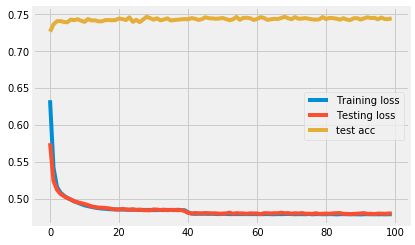

In [922]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.plot(results.history['val_acc'], label='test acc')
plt.legend();

The neural network doesnt seem to be performing well and needs to be reviewed.

---

## Model 2: Restaurants with 3 and more Inspection Visits

In [923]:
X2, y2 = model2_df.iloc[:,:-1],model2_df.iloc[:,-1]

In [924]:
X2 = pd.get_dummies(X2)

### Split the Data to Train and Test

In [925]:
# in train_test_split, maintain proportion of labels by stratified
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42,  stratify=y2)

### Scaling

In [926]:
ss = StandardScaler()
X_train2_ss = ss.fit_transform(X_train2)
X_test2_ss = ss.transform(X_test2)

### Logistic Regression 

In [927]:
# fill the dictionary of parameters
gs_params = {'penalty':['l1','l2'],
             'C':np.logspace(-3,0,10)}

#create gridsearch object
lr_grid = GridSearchCV(LogisticRegression(), 
                             gs_params, 
                             n_jobs=-1, cv=5, verbose=1)
lr_grid.fit(X_train2_ss, y_train2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([0.001  , 0.00215, 0.00464, 0.01   , 0.02154, 0.04642, 0.1    ,
       0.21544, 0.46416, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [928]:
# find the best mean cross-validated score that gridsearch found
lr_grid.best_score_

0.727709217888179

In [930]:
# find the best hyperparameters that gridsearch found
lr_grid.best_params_

{'C': 0.01, 'penalty': 'l1'}

In [934]:
# assign the best estimator to a variable
best_lr = lr_grid.best_estimator_

In [935]:
# score the best estimator on the testing data
best_lr.score(X_test2_ss, y_test2)

0.7282466373050828

In [936]:
lr_y2_pred = best_lr.predict(X_test2_ss)

#### Evaluation Metrics

In [937]:
confusion_matrix(y_test2, lr_y2_pred)

array([[4161,  755],
       [1528, 1957]], dtype=int64)

In [938]:
accuracy_score(y_test2, lr_y2_pred)

0.7282466373050828

In [939]:
precision_score(y_test2, lr_y2_pred)

0.7216076696165191

### Decision Tree Classifier

In [940]:
depth_range = range(1, 5)
leaf_range = range(1,15)
#n_estimators
param_grid = dict(max_depth=depth_range)
d_tree = DecisionTreeClassifier()
dt_grid = GridSearchCV(d_tree, param_grid, cv=10, scoring='accuracy')
dt_grid.fit(X_train2, y_train2)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [941]:
print(dt_grid.best_score_)

0.7262410221816594


In [942]:
print(dt_grid.best_params_)

{'max_depth': 1}


In [943]:
print(dt_grid.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [944]:
best_dt = dt_grid.best_estimator_

In [945]:
dt_y2_pred = best_dt.predict(X_test2)

#### Evaluation Metrics

### Evaluation Metrics

In [946]:
confusion_matrix(y_test2, dt_y2_pred)

array([[3765, 1151],
       [1192, 2293]], dtype=int64)

In [947]:
accuracy_score(y_test2, dt_y2_pred)

0.7211046304011427

In [948]:
precision_score(y_test2, dt_y2_pred)

0.6657955865272939

### Random Forests

In [949]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [100,120],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8],
    'criterion' :['gini']
}
rf_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rf_grid.fit(X_train2, y_train2)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 120], 'max_depth': [6, 7, 8], 'criterion': ['gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [950]:
rf_grid.best_params_

{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 120}

In [951]:
rf_grid.best_score_

0.7255267648109202

In [952]:
best_rf = rf_grid.best_estimator_

In [953]:
rf_y2_pred = best_rf.predict(X_test2)

#### Evaluation Metrics

In [954]:
confusion_matrix(y_test2, rf_y2_pred)

array([[3785, 1131],
       [1227, 2258]], dtype=int64)

In [955]:
accuracy_score(y_test2, rf_y2_pred)

0.7193191286751577

In [956]:
precision_score(y_test2, rf_y2_pred)

0.6662732369430511

## XGBoost

### XGBoost with Grid Search

In [957]:
dmatrix = xgb.DMatrix(data=X2,label=y2)


params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross_validation: cv_results
xg_cv = xgb.cv(dtrain=dmatrix, params=params, nfold=3, num_boost_round=5, metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(xg_cv)

# Print the AUC
print((xg_cv["test-auc-mean"]).iloc[-1])

C:\Users\noura\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\noura\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0  0.797298        0.000786       0.795971       0.002337    
1  0.799550        0.000452       0.798440       0.003223    
2  0.801374        0.001097       0.800647       0.002165    
3  0.801951        0.000532       0.801213       0.002507    
4  0.802403        0.000967       0.801653       0.002337    
0.8016533333333333


## Model1 vs Model2

The accuracy & precision of our model has decreased througout the four algorithms used. It seems that our models perform better with the whole dataset than with restaurants with 3 and more inspections.

| Model | Accuracy-Model1 | Accuracy-Model2 |Precision-Model1 |Precision-Model2 |
|------|------|------|
|   Logistic Regression  | 0.742 | 0.728 | 0.729 |0.721 |
|   Decision Tree  | 0.742 | 0.721 | 0.773 | 0.665 |
|   Random Forrest  | 0.743 | 0.719 | 0.734 | 0.666 |
|   XGBoost with CV  | 0.836 | 0.801 |  |   |


# Conclusion

In this research project we tried to predict restaurant inspection results using weather data, community area features, chain size, restaurant risk level, and percentage of past failed visists (failed here includes pass with conditions). According to our analysis and our models' feature importance, the feature that has the highest correlation with the results of an inspection is the percentage of past failed inspections. Other features also correlated with an inspection's results, but very weakly.

We created two models, one for the complete dataset, and another for the observations with more than two insepctions. According to our results, the first model outperformed the second one.

Our recommendation for future work is to add more features to the dataset, mainly features about the restaurants themselves. Other than the restaurant risk level and the chain size, our dataset was lacking information about the restaurants themselves, such as the type of cuisine, the price range, and customer ratings from social media. 

Furthermore, the community area could be investigated further. According to the feature importance of the models, some community areas are either positively or negatively correlated with the results of an inspection. We could add a feature that represents the 9 regions of Chicago, they might show a pattern that we could not see with 77 community areas. 